In [2]:
import numpy as np
import pandas as pd
from aerobot.io import RESULTS_PATH, ASSET_PATH, FEATURE_TYPES
from aerobot.dataset import dataset_load_all
from aerobot.models import GeneralClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticks

In [3]:
RESULTS_PATH = os.path.join(RESULTS_PATH, 'earth_microbiome')

## Running model on EMB data

EMB data is stored on HPC under `/central/groups/fischergroup/goldford/earth_microbiome/proteins`. The data file has a column for each amino acid trimer (there are over 9000). I think I will need to filter the features to match the features the model was trained on, as several columns are dropped when loading the raw feature data into a `dataset`.

In [8]:
# First step is to train a nonlinear model on the training data. 
! python ../scripts/run.py 'nonlinear' --feature-type 'aa_3mer' --save-model 1 --n-epochs 500 --save-model-path 'aa_3mer_nonlinear_model.joblib'

Training NonlinearClassifier...: 100%|██████| 500/500 [1:04:58<00:00,  7.80s/it]

Results of training a nonlinear classifier for ternary classification.
	Feature type: aa_3mer
	Balanced accuracy on training dataset: 0.9595037868370083
	Balanced accuracy on validation dataset: 0.8049397220160904

Writing results to run_model_results.pkl.
Saving trained model to aa_3mer_nonlinear_model.joblib.

Model run complete in 3185.19 seconds.


In [12]:
# Also train a logistic model on the training data. 
! python ../scripts/run.py 'logistic' --feature-type 'aa_3mer' --save-model 1 --max-iter 10000 --save-model-path 'aa_3mer_logistic_model.joblib'

/home/prichter/miniconda3/envs/aerobot/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(

Results of training a logistic classifier for ternary classification.
	Feature type: aa_3mer
	Balanced accuracy on training dataset: 0.9966855466845016
	Balanced accuracy on validation dataset: 0.7815291401001003

Writing results to run_model_results.pkl.
Saving trained model to aa_3mer_logistic_model.joblib.

Model run complete in 3.95 seconds.


In [7]:
# Get a subset of the data for testing.
# emb_data = pd.read_csv(os.path.join(RESULTS_PATH, 'emb_aa_3mer.csv'), nrows=200, index_col=0)
# emb_data.to_csv(os.path.join(RESULTS_PATH, 'emb_aa_3mer_subset.csv'))

# Comparing to original

In [8]:
# Load the original run of the logistic classifier
emb_predictions_original_df = pd.read_csv(os.path.join(RESULTS_PATH, f'original_run_results_logistic_aa_3mer.csv'), index_col=0)
emb_predictions_original_df = emb_predictions_original_df.rename(columns={'label':'prediction'})
emb_predictions_original_df.prediction = emb_predictions_original_df.prediction.str.lower()
# Load my (Pippa's) run of the logistic classifier on the new data. 
emb_predictions_logistic_df = pd.read_csv(os.path.join(RESULTS_PATH, f'run_pretrained_results_logistic_aa_3mer.csv'), index_col=0)
# Load my (Pippa's) run of the nonlinear classifier on the new data. 
emb_predictions_nonlinear_df = pd.read_csv(os.path.join(RESULTS_PATH, f'run_pretrained_results_nonlinear_aa_3mer.csv'), index_col=0)

print('Predictions from original run:')
print(emb_predictions_original_df.prediction.value_counts())

print('\nPredictions from new logistic run:')
print(emb_predictions_logistic_df.prediction.value_counts())

print('\nPredictions from new nonlinear run:')
print(emb_predictions_nonlinear_df.prediction.value_counts())


Predictions from original run:
prediction
anaerobe       26735
aerobe         23420
facultative     2360
Name: count, dtype: int64

Predictions from new logistic run:
prediction
anaerobe       28905
aerobe         20915
facultative     2695
Name: count, dtype: int64

Predictions from new nonlinear run:
prediction
anaerobe       35147
aerobe         13656
facultative     3712
Name: count, dtype: int64


## Cleaning data

In [9]:
model_class = 'logistic'

In [10]:
# Load the Earth microbiome project analysis and metadata
emb_metadata_df = pd.read_csv(os.path.join(RESULTS_PATH, 'emb_metadata.tsv'), sep='\t', index_col=0, dtype={'metagenome_id':str})
emb_predictions_df = pd.read_csv(os.path.join(RESULTS_PATH, f'run_pretrained_results_{model_class}_aa_3mer.csv'), index_col=0)
emb_predictions_df.index = emb_metadata_df.index # I think this is OK? Indices should match, no scrambling happens during predictions.
print('Number of predictions:', len(emb_predictions_df))
print('Number of metadata entries:', len(emb_metadata_df))
# Combine the predictions and metadata.
emb_predictions_df = pd.concat([emb_metadata_df, emb_predictions_df], axis=1)

Number of predictions: 52515
Number of metadata entries: 52515


In [11]:
# Replace habitat names with more general categories.
habitat_map = pd.read_csv(os.path.join(RESULTS_PATH, 'emb_habitats.csv'), index_col=0).to_dict()['habitat']
emb_predictions_df.habitat = emb_predictions_df.habitat.replace(habitat_map)

In [12]:
# Filter out low-completeness MAGs.
emb_predictions_df = emb_predictions_df[emb_predictions_df.completeness > 50]
print(len(emb_predictions_df), 'genomes with >50 percent completeness.')

# Filter out entries from samples with fewer than ten MAGs
counts = emb_predictions_df.groupby('metagenome_id').apply(len)
ids_to_keep = counts.index[counts > 10]
emb_predictions_df = emb_predictions_df[emb_predictions_df.metagenome_id.isin(ids_to_keep)]
print(len(emb_predictions_df), 'genomes from samples with more than ten genomes.')

# Filter our habitats with fewer than ten samples.
counts = emb_predictions_df.groupby('habitat').apply(len)
habitats_to_keep = counts.index[counts > 10]
emb_predictions_df = emb_predictions_df[emb_predictions_df.habitat.isin(habitats_to_keep)]
print(len(emb_predictions_df), 'genomes from habitats with more than ten samples')

52425 genomes with >50 percent completeness.
31279 genomes from samples with more than ten genomes.
31279 genomes from habitats with more than ten samples


In [18]:
# Calculate the aerobe-anaerobe-facultative fractions for each sample.
# NOTE: What is the labels column used in the original code? The prediction? Probably.

classes = set(emb_predictions_df.prediction.values) # Get the metabolic categories.
print('Metabolic categories found in the predictions:', classes)

index, rows = [], []
# Iterate through the groups of metagenomes.
for metagenome_id, df in emb_predictions_df.groupby('metagenome_id'):
    counts = df.prediction.value_counts()
    row = counts.astype(float) / counts.sum()
    row = row.to_dict()
    row = {f'{k}_fraction':v for k, v in row.items()}
    row.update(counts.astype(float).to_dict())
    row['total'] = counts.sum()
    rows.append(row)
    index.append(metagenome_id)

fractions_df = pd.DataFrame(rows, index=index)
fractions_df = fractions_df.fillna(0)

habitats_by_metagenome_id = emb_predictions_df.groupby('metagenome_id').habitat.first() # Get the habitats for each sample.
fractions_df['habitat'] = habitats_by_metagenome_id.loc[fractions_df.index]
fractions_df['aerobe_anaerobe_ratio'] = fractions_df['aerobe_fraction'] / fractions_df['anaerobe_fraction']
fractions_df.to_csv(os.path.join(RESULTS_PATH, 'emb_fractions_by_sample.csv'))

Metabolic categories found in the predictions: {'aerobe', 'anaerobe', 'facultative'}


In [19]:
# Take the mean aerobe/anaerobe fractions across habitats.
agg = {'anaerobe': 'sum', 'aerobe': 'sum', 'facultative': 'sum', 'total': 'sum', 'aerobe_anaerobe_ratio': np.nanmean}
mean_fractions_df = fractions_df.groupby('habitat').agg(agg).sort_values('total', ascending=False)
mean_fractions_df['anaerobe_fraction'] = mean_fractions_df['anaerobe'] / mean_fractions_df['total']
mean_fractions_df['aerobe_fraction'] = mean_fractions_df['aerobe'] / mean_fractions_df['total']
mean_fractions_df['facultative_fraction'] = mean_fractions_df['facultative'] / mean_fractions_df['total']

mean_fractions_df['anaerobe_percent'] = mean_fractions_df['anaerobe_fraction'] * 100
mean_fractions_df['aerobe_percent'] = mean_fractions_df['aerobe_fraction'] * 100
mean_fractions_df['facultative_percent'] = mean_fractions_df['facultative_fraction'] * 100

mean_fractions_df.to_csv(os.path.join(RESULTS_PATH, 'emb_fractions_by_habitat.csv'))

## Plotting data

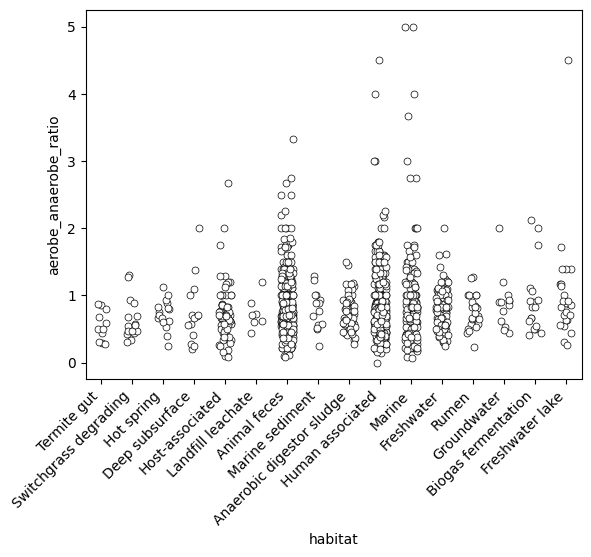

In [28]:

mean_fractions_df = pd.read_csv(os.path.join(RESULTS_PATH, 'emb_fractions_by_habitat.csv'))
fractions_df = pd.read_csv(os.path.join(RESULTS_PATH, 'emb_fractions_by_sample.csv'), index_col=0)

mean_fractions_df = mean_fractions_df[mean_fractions_df.total > 250] # Filter for habitats with more than 250 entries.
mean_fractions_df = mean_fractions_df.sort_values('aerobe_fraction', ascending=True)
fractions_df = fractions_df[fractions_df.habitat.isin(mean_fractions_df.habitat)]

fig, ax = plt.subplots()
sns.stripplot(data=fractions_df, ax=ax, x='habitat', y='aerobe_anaerobe_ratio', order=mean_fractions_df.habitat, jitter=0.2, color='white', edgecolor='k', linewidth=0.5)

ax.set_xticks(np.arange(len(mean_fractions_df.habitat)), labels=mean_fractions_df.habitat.values, rotation=45, ha='right')
plt.show()

                      habitat  total
0                Animal feces   6586
1            Human associated   4983
2                  Freshwater   2814
3                      Marine   2633
4   Anaerobic digestor sludge   1656
6                  Hot spring    614
7                       Rumen    606
8         Biogas fermentation    506
9       Switchgrass degrading    494
10                Groundwater    419
11            Freshwater lake    416
12            Deep subsurface    357
13            Marine sediment    320
14                Termite gut    319
15          Landfill leachate    269
16                 Salt marsh    247
17                   Sediment    245
18        Hot spring sediment    243


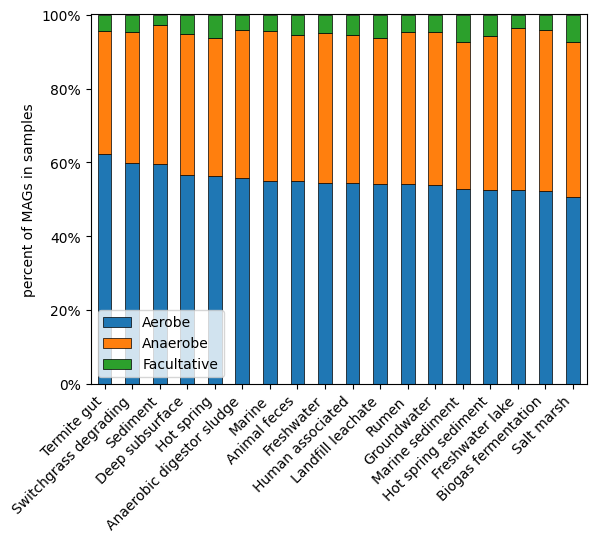

In [35]:

fig, ax = plt.subplots()
cols = ['habitat', 'anaerobe_percent', 'aerobe_percent', 'facultative_percent']
mean_fractions_df = pd.read_csv(os.path.join(RESULTS_PATH, 'emb_fractions_by_habitat.csv'))
mean_fractions_df = mean_fractions_df[(mean_fractions_df.total > 240) & ~mean_fractions_df.habitat.str.match('Host-associated')]

# Print the totals to verify that filtering worked.
# These are identical to values in original run. 
# print(mean_fractions_df[['habitat', 'total']])

mean_fractions_df = mean_fractions_df[cols].set_index('habitat').sort_values('anaerobe_percent', ascending=False)

mean_fractions_df.plot(kind='bar', stacked=True, ax=ax, legend=False, edgecolor='k', linewidth=0.5)
ax.legend(['Aerobe', 'Anaerobe', 'Facultative'], loc=3)
ax.set_ylabel('percent of MAGs in samples')
ax.set_xlabel('')
ax.set_xticks(np.arange(len(mean_fractions_df.index)), labels=mean_fractions_df.index.values, rotation=45, ha='right')
ax.set_ylim(0, 100.1)
ax.yaxis.set_major_formatter(ticks.PercentFormatter())


In [17]:
# # Load the black sea metadata
# black_sea_metadata = pd.read_csv('../../results/black-sea/meta_data.csv', index_col=0)
# black_sea_metadata['depth_m'] = black_sea_metadata['Depth'].str.strip('m').astype(float)

# # Chemical measurements are from Sollai et al. 2019 Geobiology. In their figure 1
# # it's clear these are in uM units despite what it says in our metadata file, which
# # was downloaded from the SRA at this link:
# # https://www.ncbi.nlm.nih.gov/Traces/study/?query_key=3&WebEnv=MCID_6582027b68a595196d9af8e7&o=acc_s%3Aa
# # uM units make sense as the Henry's law equilibrium of O2 in seawater is ~200 uM.
# black_sea_metadata['o2_uM'] = black_sea_metadata.diss_oxygen.str.strip('mmol / kg').astype(float)
# black_sea_metadata['h2s_uM'] = black_sea_metadata['hydrogen_sulfide'].str.strip('mM').astype(float)
# black_sea_metadata.sort_values('depth_m', inplace=True)

In [85]:
# # Load the black sea MAG inference results
# black_sea_aerotypes = pd.read_csv('../../results/black-sea/black_sea_aerotypes.aa3merModel.csv', index_col=0)
# black_sea_MAG_fractions = pd.read_csv('../../results/black-sea/blackSea.MAGfraction.04Feb2023.csv', index_col=0).drop('*')

# black_sea_MAG_fractions['aerotype'] = black_sea_aerotypes.loc[black_sea_MAG_fractions.index]
# O2_utilzation_fracs = black_sea_MAG_fractions.groupby('aerotype').sum().T
# O2_utilization_pcts = O2_utilzation_fracs*100

# # Check the totals
# totals = O2_utilization_pcts.sum(axis=1)
# assert (totals - 100).abs().max() < 1e-6

# O2_utilization_pcts['depth_m'] = black_sea_metadata.loc[O2_utilization_pcts.index].depth_m
# O2_utilization_pcts.sort_values('depth_m', inplace=True)
# O2_utilization_pcts.head()

In [86]:
# # Perform regression analysis of O2/H2S ratio vs. aerobe/anaerobe ratio
# ox_sulfide_ratio = black_sea_metadata.o2_uM/black_sea_metadata.h2s_uM
# aerobe_anaerobe_ratio = O2_utilization_pcts.Aerobe/O2_utilization_pcts.Anaerobe

# # linear regression of the log-log data
# log_ox_sulfide_ratio = np.log10(ox_sulfide_ratio)
# log_aerobe_anaerobe_ratio = np.log10(aerobe_anaerobe_ratio)

# reg_res = linregress(log_aerobe_anaerobe_ratio, log_ox_sulfide_ratio)
# print(reg_res)
# xs = np.logspace(-0.8, 2.1, 100)
# pred_ys = reg_res.intercept + reg_res.slope*np.log10(xs)

habitat
Rumen                         606.0
Animal feces                 6639.0
Switchgrass degrading         494.0
Biogas fermentation           506.0
Termite gut                   319.0
Sediment                      245.0
Anaerobic digestor sludge    1656.0
Human associated             4983.0
Hot spring                    614.0
Landfill leachate             269.0
Marine sediment               320.0
Hot spring sediment           243.0
Deep subsurface               357.0
Groundwater                   419.0
Freshwater                   2814.0
Marine                       2633.0
Freshwater lake               416.0
Salt marsh                    247.0
Name: total, dtype: float64


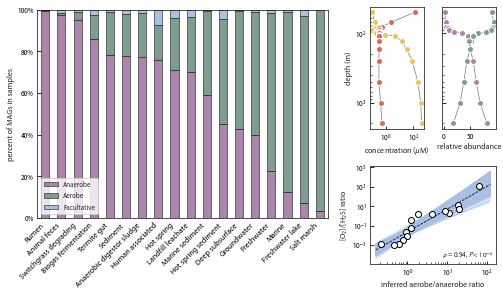

In [ ]:
# fig = plt.figure(figsize=(6.875, 4), constrained_layout=True)
# subfigs = fig.subfigures(nrows=1, ncols=2, wspace=0.02,
#                          width_ratios=[2,1])

# leftAx = subfigs[0].subplots(nrows=1, ncols=1)
# rightAxs = subfigs[1].subplots(nrows=2, ncols=2, sharey='row',
#                                gridspec_kw={'height_ratios': [1.25, 1]})

# plt.sca(rightAxs[0, 0])
# # Invert only the first -- also inverts the second since they share a y-axis.
# plt.gca().invert_yaxis()
# plt.xscale('log')
# plt.yscale('log')
# plt.plot(black_sea_metadata.h2s_uM, black_sea_metadata.depth_m, marker='o', ls='-', lw=0.75,
#          color='grey', markerfacecolor=colors['yellow'], markeredgecolor='w', label='H$_2$S')
# plt.plot(black_sea_metadata.o2_uM, black_sea_metadata.depth_m, marker='o', ls='-', lw=0.75,
#          color='grey', markerfacecolor=colors['red'], markeredgecolor='w', label='O$_2$')
# plt.xlabel('concentration ($\mu$M)')
# plt.ylabel('depth (m)')

# plt.sca(rightAxs[0, 1])
# plt.yscale('log')
# for i, col in enumerate('Anaerobe,Aerobe'.split(',')):
#     plt.plot(O2_utilization_pcts[col], O2_utilization_pcts.depth_m, marker='o', ls='-', lw=0.75,
#          color='grey', markerfacecolor=default_pal[i], markeredgecolor='w', label=col)
# #plt.ylabel('Depth (m)')
# plt.xlabel('relative abundance')

# # Make a big axis to hold the correlation plot
# gs = rightAxs[1, 0].get_gridspec()
# # remove the underlying axes
# for ax in rightAxs[1, :]:
#     ax.remove()    
# axbig = subfigs[1].add_subplot(gs[1, :])

# plt.sca(axbig)
# plt.loglog(aerobe_anaerobe_ratio, ox_sulfide_ratio, marker='o', ls='', color='grey', markerfacecolor='w', markeredgecolor='k')

# plt.plot(xs, 10**pred_ys, color='k', ls='--', lw=0.75, zorder=-1)
# # bootstrap a confidence interval plot manually because
# # seaborns regplot doesn't handle log scale...
# for _ in range(1000):
#     slope = np.random.normal(reg_res.slope, reg_res.stderr)
#     intercept = np.random.normal(reg_res.intercept, reg_res.intercept_stderr)
#     pred_ys = intercept + slope*np.log10(xs)
#     plt.plot(xs, 10**pred_ys, color=colors['light_blue'], ls='-', lw=0.5, alpha=0.8,
#              zorder=-10)

# plt.xlabel('inferred aerobe/anaerobe ratio')
# plt.ylabel('[O$_2$]/[H$_2$S] ratio')
# plt.text(0.98, 0.03, '$\\rho$ = {0:.2f}, $P < 10^{{-6}}$'.format(reg_res.rvalue, reg_res.pvalue),
#          fontsize=7, transform=plt.gca().transAxes, ha='right', va='bottom')


# plt.savefig('../../results/Fig2.png', dpi=300, facecolor='w')